This code is written to make raw data to show the prediction of both large and small events.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cte
import matplotlib.font_manager as fm
from scipy.interpolate import interp1d
import sys
from ProcessFunctions import ReadData,Find_T_X_tau_without_p_input
import pandas as pd
sys.path.append('/central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src')  # For pyqdyn
import joblib
from pyqdyn import qdyn

In [2]:
# These are the variables that I am using here
# slip rate and theta nonuniform (in time) from qdyn are named V_ox and theta_ox, the time of the qdyn simulation is also t_ox
# V_ox_uniform and stress_ox_uniform are the uniform (in time) slip rate and stress from qdyn
# The observed slip rate is called V_ox_ROM_obs which is corrupted by noise and a low pass filter
# time_inversion is the time asscoiated with the inversion time series. It starts with 0. 
# start_time is the time when we start the data assimilation algorithm.
# V_ox_ROM_inverted and theta_ox_ROM_inverted are the inverted slip rate and theta uniform (in time) from the data assimilation algorithm


In [39]:
N_m_v_list=[20,25,30]
N_m_theta_list=[20,25,30]
index=2
number=107 # index of the initial condition
PlotSmallEvents=False
Obs_linear=0
N_t=4000
m=80
sigma_kernel=2000
gamma_ratio=0.0001*5

N_m_v=N_m_v_list[index]
N_m_theta=N_m_theta_list[index]
L=cte.L_asp+cte.L_buffer  
Nx=256
Nw=32
W=cte.W  
t_yr=cte.t_yr
cmap="jet"
size_x=256
size_y=32
size=size_x*size_y
L_thresh=1e3 # to define an event
V_thresh=(5e-8) # to define an event
L_fault=L
mu=30e9
version=2024.11

In [4]:
# QDYN: importing the data that is being using for the inversion (True data)
Tf = 250 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_load=30
coeff=2 # How the inital conditions are from the chaotic attractor
data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/Dataset2/SampleSimulation_Tf"+str(Tf)+"Nt="+str(Nt)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
data_smaple=np.load(data_dir)
V_ox=data_smaple['array1']
theta_ox=data_smaple['array2']
t_ox=data_smaple['array3']
filter_ratio=0.6
Start_index=int(V_ox.shape[0]*filter_ratio)
start_time=t_ox[Start_index,0,0]/t_yr


In [5]:
# POD: importing the POD data for v and theta
# Loading POD modes
data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyonV.npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']
Sigma_v=np.diagonal(S_v)
Nt2=VT_v.shape[0]
Lambda_v=Sigma_v**2/Nt2 # Covariance matrix


data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyontheta.npz"
PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']
Sigma_theta=np.diagonal(S_theta)
Nt2=VT_theta.shape[0]
Lambda_theta=Sigma_theta**2/Nt2 # Covariance matrix
N_m_load=30
phi=U_v[:,:N_m_load]    # This contains the eigen mode for velocity

In [6]:
# INVERSION: importing the inversion results
# The data is saved using this line of code:
# np.savez("/central/groups/astuart/hkaveh/Data/LearnROM/EnKF_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number),alpha_a=alpha_a,alpha_f=alpha_f,Innovations=Innovations,time=time,y_obs=y_obs[:,:N_t],X_uniform=X_uniform[:N_t,:],t_0=t_0,number=number)
# now we load the data

data=np.load("/central/groups/astuart/hkaveh/Data/LearnROM/EnKF_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+'.npz')
alpha_a=data['alpha_a']
alpha_f=data['alpha_f']
Innovations=data['Innovations']
time_inversion=data['time']
y_obs=data['y_obs']
X_uniform=data['X_uniform']
t_0_inversion=data['t_0']
theta_data=X_uniform[:,N_m_v:].T
end_time=time_inversion[-1]/t_yr

In [7]:
print(start_time,t_0_inversion/t_yr)

150.86721241297897 [150.86721241]


In [8]:
time_inversion[-1]/24/3600/5

4000.0

In [9]:
alpha_a.shape

(40, 80, 4000)

In [10]:
y_obs.shape


(20, 4000)

In [11]:
# Changing y_obs into time seris of observed slip rate
U_ROM_V=U_v[:,0:N_m_v_list[index]]
V_ox_ROM_obs=np.zeros((y_obs.shape[1],size_y,size_x))
for j in range(y_obs.shape[1]):
    V_snapshot = U_ROM_V @ y_obs[:,j]+ q_bar_v.reshape(size,)
    V_snapshot = V_snapshot[:size_x * size_y].reshape(size_y, size_x)
    V_ox_ROM_obs[j,:,:]=10**(V_snapshot)



In [12]:
# Changing alpha_a into time seris of inverted slip rate

V_ox_ROM_inverted=np.zeros((alpha_a.shape[2],size_y,size_x))
ave_alpha=np.mean(alpha_a,axis=1)
ave_alpha_v=ave_alpha[0:N_m_v_list[index],:]


for j in range(ave_alpha_v.shape[1]):
    V_snapshot = U_ROM_V @ ave_alpha_v[:,j]+ q_bar_v.reshape(size,)
    V_snapshot = V_snapshot[:size_x * size_y].reshape(size_y, size_x)
    V_ox_ROM_inverted[j,:,:]=10**(V_snapshot)

In [13]:
U_ROM_theta=U_theta[:,0:N_m_theta_list[index]] # picking the first N_m_theta modes
theta_ox_ROM_inverted=np.zeros((alpha_a.shape[2],size_y,size_x)) # initializing the inverted theta
ave_alpha_theta=ave_alpha[N_m_v_list[index]:,:] # picking the inverted theta
for j in range(ave_alpha_theta.shape[1]): # looping over the time steps
    theta_snapshot = U_ROM_theta @ ave_alpha_theta[:,j]+ q_bar_theta.reshape(size,) # reconstructing the theta
    theta_snapshot = theta_snapshot[:size_x * size_y].reshape(size_y, size_x)
    theta_ox_ROM_inverted[j,:,:]=10**(theta_snapshot)

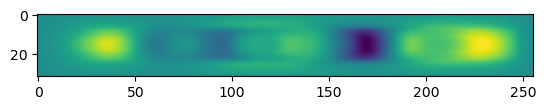

In [14]:
plt.imshow(np.log10(theta_ox_ROM_inverted[1000,:,:]))

In [15]:
# loading the dictinary of a,b,drs,f0,v0,sigma
mesh_dict=np.load("/central/groups/astuart/hkaveh/Data/LearnROM/meshdict.npz")
a_array=mesh_dict['a']
b_array=mesh_dict['b']
drs_array=mesh_dict['drs']
f0=mesh_dict['f0']
v0=mesh_dict['V0']
sigma=mesh_dict['sigma']
def findstress(v,theta):
    stress=sigma*(f0+a_array*np.log(v/v0)+b_array*np.log(v0*theta/drs_array))
    return stress



In [16]:
# Now that you have theta and sliprate you can simply find the stress
stress_inverted=findstress(V_ox_ROM_inverted,theta_ox_ROM_inverted)

Text(0.5, 1.0, 'potential good fig for paper')

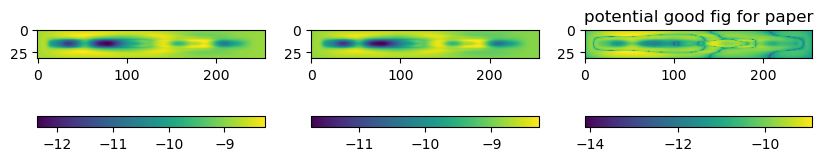

In [17]:
# plotting two figures
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])
ax0 = plt.subplot(gs[0])
pl=ax0.imshow(np.log10(V_ox_ROM_inverted[500,:,:]))
fig.colorbar(pl, ax=ax0,orientation='horizontal')
ax1=plt.subplot(gs[1])
pl=ax1.imshow(np.log10(V_ox_ROM_obs[500,:,:]))
fig.colorbar(pl, ax=ax1,orientation='horizontal')

ax2=plt.subplot(gs[2])
pl=ax2.imshow(np.log10(np.abs(V_ox_ROM_inverted[500,:,:]-V_ox_ROM_obs[500,:,:])))
fig.colorbar(pl, ax=ax2,orientation='horizontal')
plt.title("potential good fig for paper")

In [18]:
# Note that V_ox is with nonuniform time stepping. To subtract from the analysis step, we need to interpolate it to the uniform time stepping
# The unifor time is called time_inversion
# the nonuniform time is called t_ox
# we call the uniformed V_ox as V_ox_uniform
V_ox_uniform=np.zeros((len(time_inversion),size_y,size_x))
for i in range(size_y):
    for j in range(size_x):
        f = interp1d(t_ox[:,i,j], V_ox[:,i,j], kind='linear')
        V_ox_uniform[:,i,j]=f(time_inversion+t_0_inversion)





In [19]:
stress_ox=findstress(V_ox,theta_ox)

# interpolating the stress to the uniform time stepping
stress_ox_uniform=np.zeros((len(time_inversion),size_y,size_x))
for i in range(size_y):
    for j in range(size_x):
        f = interp1d(t_ox[:,i,j], stress_ox[:,i,j], kind='linear')
        stress_ox_uniform[:,i,j]=f(time_inversion+t_0_inversion)
        

In [20]:
time_inversion[-1]/24/3600/365

54.794520547945204

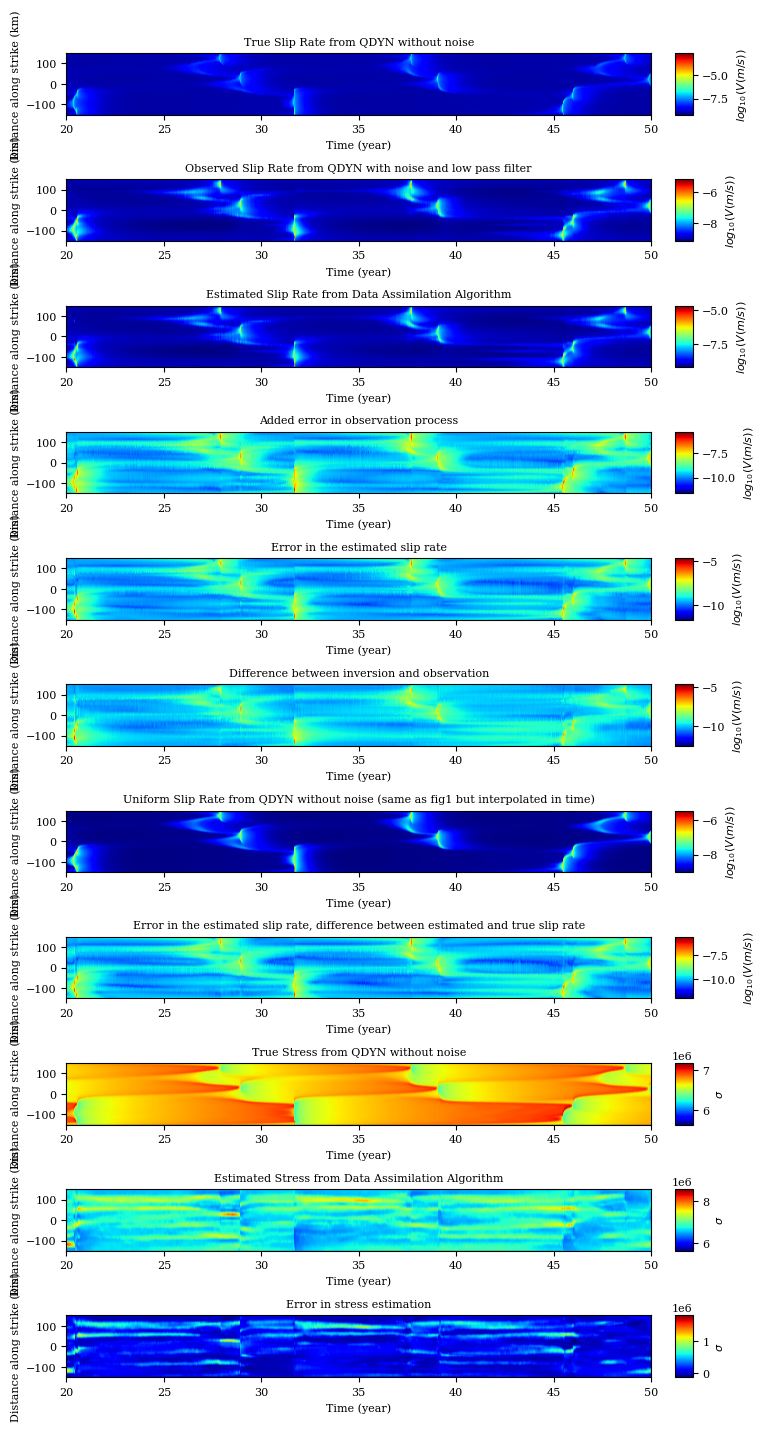

In [ ]:
# plotting Slip Rate
#,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max)
xlimleft=20
xlimright=50
fig = plt.figure(figsize=(7.7, 14))
serif_font = fm.FontProperties(family="serif", size=8)
# Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
gs = gridspec.GridSpec(nrows=11, ncols=2,width_ratios=[1,.03]) 

axes1 = fig.add_subplot(gs[0, 0]) # True slip rate 
axes2 = fig.add_subplot(gs[1, 0]) # observed slip rate
axes3 = fig.add_subplot(gs[2, 0]) # estimated slip rate
axes4 = fig.add_subplot(gs[3, 0]) # Error in slip rate
axes5 = fig.add_subplot(gs[4, 0]) # Error in slip rate
axes6 = fig.add_subplot(gs[5, 0]) # Error in slip rate
axes7 = fig.add_subplot(gs[6, 0]) # Error in slip rate
axes8 = fig.add_subplot(gs[7, 0]) # Error in slip rate
axes9 = fig.add_subplot(gs[8, 0]) # observed stress
axes10 = fig.add_subplot(gs[9, 0]) # inverted stress
axes11 = fig.add_subplot(gs[10, 0]) # inverted stress

cax1 = fig.add_subplot(gs[0, 1])  
cax2 = fig.add_subplot(gs[1, 1])  
cax3 = fig.add_subplot(gs[2, 1])  
cax4 = fig.add_subplot(gs[3, 1])
cax5 = fig.add_subplot(gs[4, 1])
cax6 = fig.add_subplot(gs[5, 1])
cax7 = fig.add_subplot(gs[6, 1])
cax8 = fig.add_subplot(gs[7, 1])
cax9 = fig.add_subplot(gs[8, 1])
cax10 = fig.add_subplot(gs[9, 1])
cax11 = fig.add_subplot(gs[10, 1])

# axes1 
V_thresh_min=1e-9
V_thresh_max=1e-6   
x_ox=np.linspace(-L/2,L/2,Nx)
V_dip_mean=np.max(V_ox,axis=1).T   # Mean Velocity along the dip
Nt=t_ox.shape[0]
x_ox_t=np.vstack([x_ox]*Nt).T # what?
time=np.max(t_ox,axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time  
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
PrettyV=np.reshape(V_dip_mean.T,-1)
    
pl=axes1.scatter(PrettyTime/t_yr-start_time,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)  
axes1.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes1.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes1.set_xlim(left=xlimleft,right=xlimright)
axes1.set_title(r'True Slip Rate from QDYN without noise',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax1)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
axes1.set_ylim(bottom=-150,top=150)

# axes 2 
Nt=y_obs.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T 
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
V_dip_mean=np.max(V_ox_ROM_obs,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes2.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)  
axes2.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes2.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes2.set_xlim(left=xlimleft,right=xlimright)
axes2.set_title(r'Observed Slip Rate from QDYN with noise and low pass filter',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax2)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
axes2.set_ylim(bottom=-150,top=150)

# axes 3
Nt=ave_alpha_v.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
V_dip_mean=np.max(V_ox_ROM_inverted,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes3.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
axes3.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes3.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes3.set_title(r'Estimated Slip Rate from Data Assimilation Algorithm',fontproperties=serif_font)
axes3.set_xlim(left=xlimleft,right=xlimright)
b=fig.colorbar(pl,cax=cax3)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
axes3.set_ylim(bottom=-150,top=150)

# axes 4

Nt=y_obs.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T 
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
Error=np.abs(V_ox_ROM_obs-V_ox_uniform)
V_dip_mean=np.max(Error,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes4.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)  
axes4.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes4.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes4.set_title(r'Added error in observation process',fontproperties=serif_font)
axes4.set_xlim(left=xlimleft,right=xlimright)
b=fig.colorbar(pl,cax=cax4)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
axes4.set_ylim(bottom=-150,top=150)

# axes 5

Nt=ave_alpha_v.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
Error=np.abs(V_ox_ROM_inverted-V_ox_uniform)


V_dip_mean=np.max(Error,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes5.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
axes5.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes5.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes5.set_xlim(left=xlimleft,right=xlimright)
axes5.set_title(r'Error in the estimated slip rate',fontproperties=serif_font)  
b=fig.colorbar(pl,cax=cax5)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
axes5.set_ylim(bottom=-150,top=150)


# axes 6

Nt=ave_alpha_v.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
Error=np.abs(V_ox_ROM_inverted-V_ox_ROM_obs)


V_dip_mean=np.max(Error,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes6.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
axes6.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes6.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes6.set_title(r'Difference between inversion and observation',fontproperties=serif_font)
axes6.set_xlim(left=xlimleft,right=xlimright)
b=fig.colorbar(pl,cax=cax6)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
axes6.set_ylim(bottom=-150,top=150)

# axes 7

Nt=ave_alpha_v.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)

V_dip_mean=np.max(V_ox_uniform,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes7.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
axes7.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes7.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes7.set_xlim(left=xlimleft,right=xlimright)
axes7.set_title(r'Uniform Slip Rate from QDYN without noise (same as fig1 but interpolated in time)',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax7)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
axes7.set_ylim(bottom=-150,top=150)


# axes 8

Nt=ave_alpha_v.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
Error=np.abs(V_ox_ROM_inverted-V_ox_uniform)
V_dip_mean=np.mean(Error,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes8.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
axes8.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes8.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes8.set_xlim(left=xlimleft,right=xlimright)
axes8.set_title(r'Error in the estimated slip rate, difference between estimated and true slip rate',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax8)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
axes8.set_ylim(bottom=-150,top=150)

# axes 9

Nt=y_obs.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
V_dip_mean=np.max(stress_ox_uniform,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes9.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=(PrettyV),cmap=cmap,linewidths=1)
axes9.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes9.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes9.set_xlim(left=xlimleft,right=xlimright)
axes9.set_title(r'True Stress from QDYN without noise',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax9)
b.set_label(label=r'$\sigma$',fontproperties=serif_font)
axes9.set_ylim(bottom=-150,top=150)

# axes 10

Nt=ave_alpha_v.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
V_dip_mean=np.max(stress_inverted,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes10.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=(PrettyV),cmap=cmap,linewidths=1)
axes10.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes10.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes10.set_xlim(left=xlimleft,right=xlimright)
axes10.set_title(r'Estimated Stress from Data Assimilation Algorithm',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax10)
b.set_label(label=r'$\sigma$',fontproperties=serif_font)
axes10.set_ylim(bottom=-150,top=150)


# axes 11

Nt=ave_alpha_v.shape[1]
x_ox_t=np.vstack([x_ox]*Nt).T
time = np.tile(time_inversion, (256, 1))
PrettyTime=np.reshape(time.T,-1)
Prettyx=np.reshape(x_ox_t.T,-1)
V_dip_mean=np.max(stress_inverted-stress_ox_uniform,axis=1).T   # Mean Velocity along the dip
PrettyV=np.reshape(V_dip_mean.T,-1)

pl=axes11.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=(PrettyV),cmap=cmap,linewidths=1)
axes11.set_xlabel(r'Time (year)',fontproperties=serif_font)
axes11.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
axes11.set_xlim(left=xlimleft,right=xlimright)
axes11.set_title(r'Error in stress estimation',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax11)
b.set_label(label=r'$\sigma$',fontproperties=serif_font)
axes11.set_ylim(bottom=-150,top=150)
plt.tight_layout()
plt.show()



In [21]:
ave_alpha_v.shape[1]


4000

In [22]:
max_index = np.unravel_index(np.argmax(V_ox_uniform), V_ox_uniform.shape)


In [23]:
V_ox_uniform.shape

(4000, 32, 256)

In [24]:
print(np.max(V_ox_uniform[max_index,:,:]))


1.8626501373301013e-06


Text(0.5, 1.0, 'Error in Slip Rate')

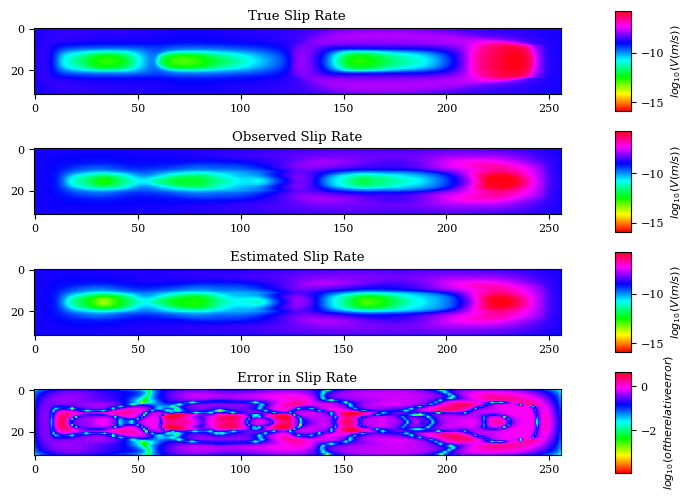

In [25]:
# Plotting a figure to show the effect of inversion
# The plot should have 4 panels.
# 1- True slip rate
# 2- Observed slip rate
# 3- Estimated slip rate
# 4 - Error in the slip rate
# The slip rate is plotted for a specific time step
vmax=np.log10(np.max(V_ox_uniform[max_index,:,:]))
vmin=np.log10(np.min(V_ox_uniform[max_index,:,:]))
index=max_index[0]
fig = plt.figure(figsize=(7.7, 6))
serif_font = fm.FontProperties(family="serif", size=8)
cmap='hsv'
# Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
gs = gridspec.GridSpec(nrows=4, ncols=2,width_ratios=[1,.03]) 
ax1= fig.add_subplot(gs[0, 0]) # True slip rate
ax2= fig.add_subplot(gs[1, 0]) # Observed slip rate
ax3= fig.add_subplot(gs[2, 0]) # Estimated slip rate
ax4= fig.add_subplot(gs[3, 0]) # Error in slip rate
cax1 = fig.add_subplot(gs[0, 1])
cax2 = fig.add_subplot(gs[1, 1])
cax3 = fig.add_subplot(gs[2, 1])
cax4 = fig.add_subplot(gs[3, 1])
pl=ax1.imshow(np.log10(V_ox_uniform[index,:,:]),cmap=cmap,vmin=vmin,vmax=vmax)
b=fig.colorbar(pl,cax=cax1)
ax1.set_title('True Slip Rate')
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
pl=ax2.imshow(np.log10(V_ox_ROM_obs[index,:,:]),cmap=cmap,vmin=vmin,vmax=vmax)
b=fig.colorbar(pl,cax=cax2)
ax2.set_title('Observed Slip Rate')
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
pl=ax3.imshow(np.log10(V_ox_ROM_inverted[index,:,:]),cmap=cmap,vmin=vmin,vmax=vmax)
b=fig.colorbar(pl,cax=cax3)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
ax3.set_title('Estimated Slip Rate')
pl=ax4.imshow(np.log10(np.abs(V_ox_uniform[index,:,:]-V_ox_ROM_inverted[index,:,:])/(V_ox_uniform[index,:,:])),cmap=cmap)
b=fig.colorbar(pl,cax=cax4)
b.set_label(label=r'$log_{10}(of the relative error)$',fontproperties=serif_font)

ax4.set_title('Error in Slip Rate')




In [26]:
V_ox_ROM_obs[index,0,0]-V_ox_ROM_inverted[index,0,0]

-6.297553904916923e-12

In [27]:
V_ox_ROM_inverted[index,0,0]

1.2782971421960685e-09

From these simulations, I understood that most of the error comes from the model reduction. So, if you plot the absolute error it might be large. But it is the best thing you can d in this coordinate. So, if you want to show how well the inversion works, you might only want to plot the $l^2$ error betweeen the inerted and the actual stress and not the $L^2$ error.

With this insight let's write the code to find stress.


To find the stress, you need $f_0$, a, b, drs, v, theta

Ok, now lets import the eay stuff like frictional properties first. OK?

To import that, you need to import QDYN, you actually dont need to install it, but at the end of the day you need to install QDYN on HPC.

I have not installed it yet because an openmpi issue. But I have downloaded qdyn so, it should be OK to at least load the thing.

In [28]:
max_index

(552, 16, 233)

Text(0.5, 1.0, 'Error in Stress')

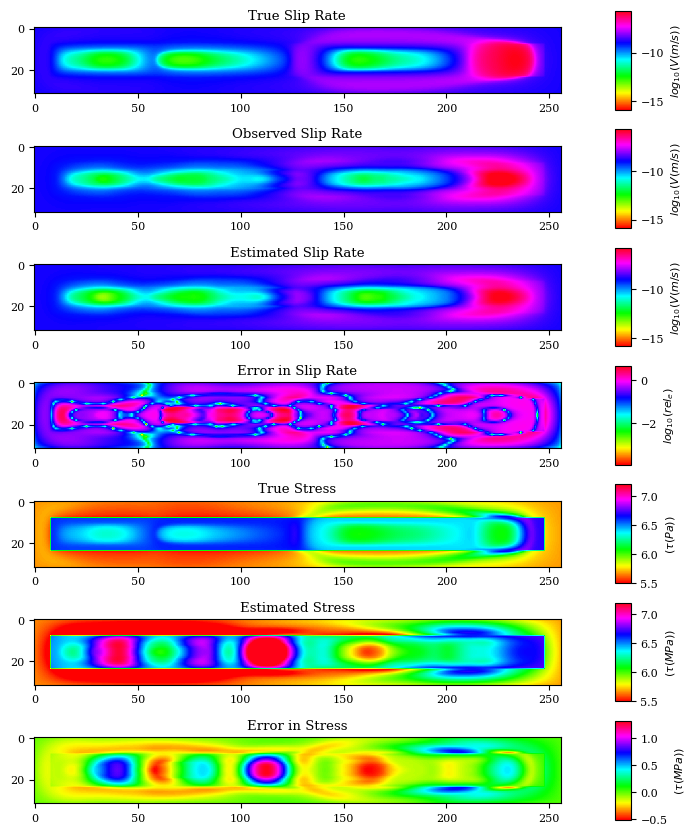

In [29]:
# Plotting a figure to show the effect of inversion
# The plot should have 4 panels.
# 1- True slip rate
# 2- Observed slip rate
# 3- Estimated slip rate
# 4 - Error in the slip rate
# The slip rate is plotted for a specific time step

cmap2="hsv"
index=max_index[0]
vmax_v=np.log10(np.max(V_ox_uniform[max_index,:,:]))
vmin_v=np.log10(np.min(V_ox_uniform[max_index,:,:]))


fig = plt.figure(figsize=(7.7, 10.5))
serif_font = fm.FontProperties(family="serif", size=8)
# Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
gs = gridspec.GridSpec(nrows=7, ncols=2,width_ratios=[1,.03]) 
ax1= fig.add_subplot(gs[0, 0]) # True slip rate
ax2= fig.add_subplot(gs[1, 0]) # Observed slip rate
ax3= fig.add_subplot(gs[2, 0]) # Estimated slip rate
ax4= fig.add_subplot(gs[3, 0]) # Error in slip rate
ax5= fig.add_subplot(gs[4, 0]) # Stress
ax6= fig.add_subplot(gs[5, 0]) # Stress
ax7= fig.add_subplot(gs[6, 0]) # Stress
cax1 = fig.add_subplot(gs[0, 1])
cax2 = fig.add_subplot(gs[1, 1])
cax3 = fig.add_subplot(gs[2, 1])
cax4 = fig.add_subplot(gs[3, 1])
cax5 = fig.add_subplot(gs[4, 1])
cax6 = fig.add_subplot(gs[5, 1])
cax7 = fig.add_subplot(gs[6, 1])
pl=ax1.imshow(np.log10(V_ox_uniform[index,:,:]),cmap=cmap,vmin=vmin_v,vmax=vmax_v)
b=fig.colorbar(pl,cax=cax1)
ax1.set_title('True Slip Rate')
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
pl=ax2.imshow(np.log10(V_ox_ROM_obs[index,:,:]),cmap=cmap,vmin=vmin_v,vmax=vmax_v)
b=fig.colorbar(pl,cax=cax2)
ax2.set_title('Observed Slip Rate')
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
pl=ax3.imshow(np.log10(V_ox_ROM_inverted[index,:,:]),cmap=cmap,vmin=vmin_v,vmax=vmax_v)
b=fig.colorbar(pl,cax=cax3)
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
ax3.set_title('Estimated Slip Rate')
pl=ax4.imshow(np.log10(np.abs(V_ox_uniform[index,:,:]-V_ox_ROM_inverted[index,:,:])/V_ox_uniform[index,:,:]),cmap=cmap)
b=fig.colorbar(pl,cax=cax4)
b.set_label(label=r'$log_{10}(rel_{e})$',fontproperties=serif_font)
ax4.set_title('Error in Slip Rate')

pl=ax5.imshow((stress_ox_uniform[index,:,:])/1e6,cmap=cmap2,vmin=5.5,vmax=7.2)
b=fig.colorbar(pl,cax=cax5)
b.set_label(label=r'$(\tau(Pa))$',fontproperties=serif_font)
ax5.set_title('True Stress')

pl=ax6.imshow((stress_inverted[index,:,:])/1e6,cmap=cmap2,vmin=5.5,vmax=7.2)
b=fig.colorbar(pl,cax=cax6)
b.set_label(label=r'$(\tau(MPa))$',fontproperties=serif_font)
ax6.set_title('Estimated Stress')

pl=ax7.imshow(((stress_inverted[index,:,:]-stress_ox_uniform[index,:,:]))/1e6,cmap='hsv')
b=fig.colorbar(pl,cax=cax7)
b.set_label(label=r'$(\tau(MPa))$',fontproperties=serif_font)
ax7.set_title('Error in Stress')




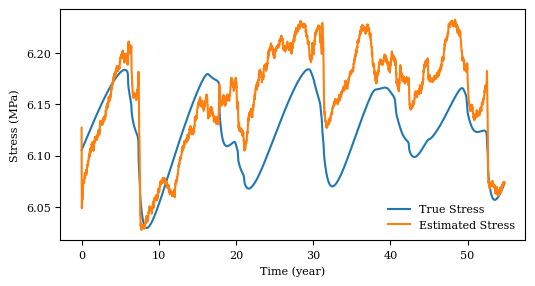

In [30]:
# plotting the time series of the average stress on the fault and the estimated average stress on the fault
ave_stress_true=np.mean(stress_ox_uniform,axis=(1,2))
ave_stress_estimated=np.mean(stress_inverted,axis=(1,2))
fig = plt.figure(figsize=(6, 3))
serif_font = fm.FontProperties(family="serif", size=8)
# Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
ax= fig.add_subplot(1, 1, 1) # True slip rate
ax.plot(time_inversion/t_yr,ave_stress_true/1e6,label='True Stress')
ax.plot(time_inversion/t_yr,ave_stress_estimated/1e6,label='Estimated Stress')
ax.legend()
ax.set_xlabel('Time (year)')
ax.set_ylabel('Stress (MPa)')
# removing the box around the legend
ax.legend(frameon=False)


In [31]:
# the nonuniform velocity and theta are called V_ox and theta_ox
# we call nonuniform stress as stress_ox


In [32]:
# to do:
# 0- to make sure I have found the stress correctly, let's plot the stress_ox_unifrom in the big plot as well. it should be easy: yes, it looks good
# 1- find the time when the events started, denote them by a dashed line in the stress plot. done
# 2- define some prediction horizen tau. done
# 3- take the inverted sliprate and theta and predict using qdyn, and see how does things go with stress. :
    # 3.1 import QDYN
    # 3.2 define the parameters same as forward simulation, make sure all of the parameters are the same
    # 3.3 define the initial condition using the inverted slip rate and theta
    # 3.4 run the simulation
    # 3.5 plot the stress and see how does it go
# This is a lot of work and I dont excpect number 3 to be finished soon.
    
# 4- can you distinguish between the predictability of the magnitude and time of the next event?


In [33]:
# 1- find the time when the events started, denote them by a dashed line in the stress plot.
# TimeStarts,TimeEnds,rectangles,Mags=Find_T_X_tau_without_p_input(V_ox,t_ox,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)

In [34]:

time_inversion.shape

(4000,)

In [35]:
V_thresh

5e-08

In [51]:
x_ox=np.linspace(-L/2,L/2,size_x)
z_ox=np.linspace(0,W,size_y)
# Expand the dimensions of 'a' to make it (1000, 1, 1)
t_expanded = time_inversion[:, np.newaxis, np.newaxis]

# Use np.tile to copy the values along the other dimensions
t_expanded = np.tile(t_expanded, (1, 32, 256))


TimeStarts,TimeEnds,rectangles,Mags=Find_T_X_tau_without_p_input(V_ox_uniform,t_expanded,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)
Nrectangles=int(rectangles.size/4)
rectangles=np.reshape(rectangles,(Nrectangles,4))
# select a magnitude threshold

Mag_thresh=6.9
Mag_lowbound=6.6
Mag_upbound=6.9
if PlotSmallEvents:
    mask=(Mags>Mag_lowbound) & (Mags<Mag_upbound)
else:
    mask=Mags>Mag_thresh
TimeStarts_filtered = TimeStarts[mask]
TimeEnds_filtered = TimeEnds[mask]
rectangles_filtered = rectangles[mask,:]
Mags_filtered = Mags[mask]



19.950776764391517
19.97816286839205
31.06953498860971
31.096921092610245
40.57251307679619
40.62728528479727
49.80163012497731
49.89748148897919


In [52]:
mask

array([ True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False])

In [53]:
Mags

array([6.77465888, 6.61894388, 7.10141161, 6.92727006, 5.99730726,
       5.45086951, 6.59070987, 6.55434429, 6.43606276, 6.57179228,
       6.41068461, 6.63221762, 6.35418741, 6.39498311, 6.54199447,
       6.54879309, 6.42821945, 7.02885592])

In [54]:
Mags_filtered.size

3

Text(0.5, 1.0, 'Maximum slip rate from the PDE and vertical lines are the big events')

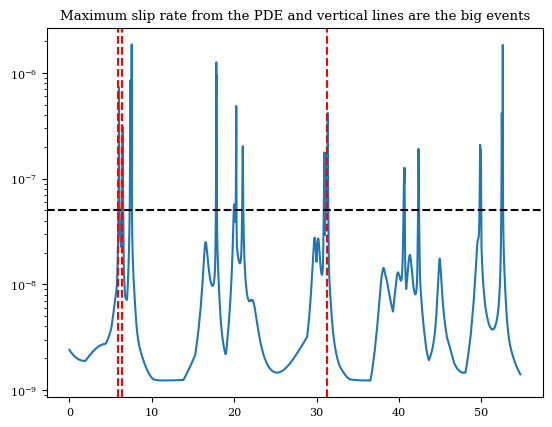

In [55]:
plt.plot(time_inversion/t_yr,np.max(V_ox_uniform,axis=(1,2)))
for i in range(TimeStarts_filtered.size):
    plt.axvline(x=TimeStarts_filtered[i]/t_yr,color='r',linestyle='--')

plt.axhline(y=V_thresh,color='k',linestyle='--')
plt.yscale('log')
plt.title('Maximum slip rate from the PDE and vertical lines are the big events')

(0.0, 60.0)

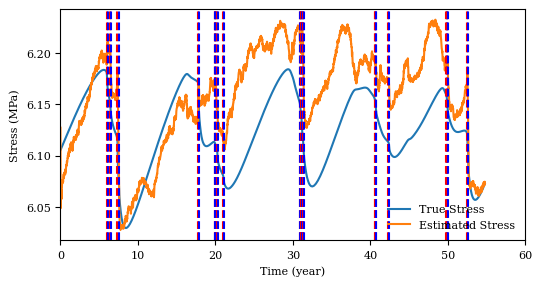

In [56]:
# plotting the time series of the average stress on the fault and the estimated average stress on the fault
xlimleft=0
xlimright=60
ave_stress_true=np.mean(stress_ox_uniform,axis=(1,2))
ave_stress_estimated=np.mean(stress_inverted,axis=(1,2))
fig = plt.figure(figsize=(6, 3))
serif_font = fm.FontProperties(family="serif", size=8)
# Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
ax= fig.add_subplot(1, 1, 1) # True slip rate
ax.plot(time_inversion/t_yr,ave_stress_true/1e6,label='True Stress')
ax.plot(time_inversion/t_yr,ave_stress_estimated/1e6,label='Estimated Stress')
ax.legend()
ax.set_xlabel('Time (year)')
ax.set_ylabel('Stress (MPa)')
# removing the box around the legend
ax.legend(frameon=False)
for i in range(len(TimeStarts)):
    ax.axvline(x=TimeStarts[i]/t_yr,linestyle='--',color='red')
    ax.axvline(x=TimeEnds[i]/t_yr,linestyle='--',color='blue')
ax.set_xlim(left=xlimleft,right=xlimright)

In [57]:
# loading qdyn from central directory

In [58]:
# take some baby steps:
# import qdyn: done
sys.path.append('/central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src')  # For pyqdyn
from pyqdyn import qdyn
# import parameters that are needed to run the forward model: done
# check that everything is properly imported: done
# define the parameters: done
# Now I want you to think about how you want to do the prediction.
# one way is to set tau. For each tau, you simulate the forward model from all [T_start - tau] up to probably 2\tau or 3\tau and plot the rupture extent
# you are predicting the magnitude and the time of the next event
# as someone who is working on earthquake forecast you need to comeup with good defenition of prediction quality



In [59]:
def forwardmodelnorthCascadia(a_VW,b_VW,dc,W_asp=25000):
    L_asp=cte.L_asp_north
    L=cte.L_asp_north+cte.L_buffer    
    stringadditional="north"
    p=forwardmodel(a_VW,b_VW,dc,W_asp,L,L_asp,stringadditional)


def forwardmodelsmallsystem(a_VW,b_VW,dc,W_asp=25000):
    L_asp=cte.L_asp
    L=cte.L_asp_north+cte.L_buffer    
    stringadditional="smallsystem"
    p=forwardmodel(a_VW,b_VW,dc,W_asp,L,L_asp,stringadditional)




In [60]:
cte.resolution

5

In [61]:
def forwardmodel(a_VW,b_VW,dc,W_asp,L,L_asp,stringadditional,T_final,u_init,Specifyinit):
        #% Specifying parameters that are always constant
    p = qdyn()
    set_dict=p.set_dict
    set_dict["MESHDIM"] = 2     # Simulation dimensionality (2D fault in 3D medium)
    set_dict["FAULT_TYPE"]= 2   # Thrust fault
    set_dict["TMAX"]= T_final # Maximum simulation time
    set_dict["NTOUT"]= cte.Ntout     # Save outputs every N steps
    set_dict["NXOUT"]=cte.Nxout         # Snapshot resolution along-strike
    set_dict["NWOUT"]=cte.Nwout         # Snapshot resolution along-dip
    set_dict["V_PL"]=cte.V_PL     # Plate velocity
    set_dict["MU"]=cte.G         # Shear modulus
    set_dict["SIGMA"]=cte.sigma       # Effective Normal stress
    set_dict["ACC"]=1e-7        # Solver Accuracy
    set_dict["SOLVER"]=2        # Solver type (Runge-Kutta)
    set_dict["Z_CORNER"] = -cte.W    # Base of the fault (depth taken <0); NOTE: Z_CORNER must be < -W !
    set_dict["DIP_W"]=cte.dipangle

    # Setting some (default) RSF parameter values
    set_dict["SET_DICT_RSF"]["A"] = cte.a_VS    # Direct effect (will NOT be overwritten later)
    set_dict["SET_DICT_RSF"]["B"] = cte.b_VS    # Evolution effect (will be overwritten later)
    set_dict["SET_DICT_RSF"]["V_SS"] = 1e-6   # Reference velocity [m/s]*
    set_dict["SET_DICT_RSF"]["V_0"] = set_dict["V_PL"]     # Initial velocity [m/s]
    set_dict["SET_DICT_RSF"]["TH_0"] = 0.99 * set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial (steady-)state [s]
    set_dict["SET_DICT_RSF"]["DC"] = dc     # Characteristic slip distance
    Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (b_VW* set_dict["SIGMA"])
        # Nucleation length [m]
    Lc = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / ((b_VW - a_VW) * set_dict["SIGMA"])
    pi1=(b_VW-a_VW)/b_VW
    pi2=dc/W_asp
    pi3=(b_VW-a_VW)*cte.sigma/cte.G
        # These parameters are not in QDYN I just need to record them for post process
    set_dict["a_VW"]=a_VW
    set_dict["b_VW"]=b_VW
    set_dict["pi1"]=pi1
    set_dict["pi2"]=pi2
    set_dict["pi3"]=pi3

        # print("pi1="+str(pi1))
        # print("pi2="+str(pi2))
        # print("pi3="+str(pi3))
        # print("h_rr/W="+str(np.pi/4*pi2/pi3))
        # print(f"Process zone size: {Lb} m \t Nucleation length: {Lc} m")
        # print("counter is "+str(counter))
    Nx = int(np.power(2, np.ceil(np.log2(cte.resolution * L / Lb))))
    Nw = int(np.power(2, np.ceil(np.log2(cte.resolution * cte.W / Lb))))


    x = np.linspace(-L/2, L/2, Nx, dtype=float)
    z = np.linspace(-cte.W/2, cte.W/2, Nw, dtype=float)
    X, Z = np.meshgrid(x, z)

        # Set mesh size and fault length
    set_dict["NX"] = Nx
    set_dict["NW"] = Nw
    set_dict["L"] = L
    set_dict["W"] = cte.W 
    set_dict["DW"] = cte.W / Nw
# Set time series output node to the middle of the fault
    set_dict["IC"] = Nx * (Nw // 2) + Nx // 2


    """ Step 2: Set (default) parameter values and generate mesh """
    p.settings(set_dict)
    p.render_mesh()
    nx=int((L_asp/L)*Nx) # Number of elements along-strike for VW region
    nw=int((W_asp/cte.W)*Nw) # Number of elements along the dip for VS region


    x_VW=np.linspace(-L_asp/2, L_asp/2, nx, dtype=float)
    z_VW=np.linspace(-W_asp/2, W_asp/2, nw, dtype=float)
    X_VW, Z_VW = np.meshgrid(x_VW, z_VW)


    B=np.ones((Nw,Nx))*cte.b_VS  
    A=np.ones((Nw,Nx))*cte.a_VS
    A[Nw//2-nw//2:Nw//2+nw//2,Nx//2-nx//2:Nx//2+nx//2]=a_VW  # a=0.004 in all of the pickle files whose a's are not specified.
    B[Nw//2-nw//2:Nw//2+nw//2,Nx//2-nx//2:Nx//2+nx//2]=b_VW  # a=0.004 in all of the pickle files whose a's are not specified.
        

    
    p.mesh_dict["A"] = A.ravel()
    p.mesh_dict["B"] = B.ravel()
    if Specifyinit==True:
        N=Nx*Nw*2
        plt.figure()
        plt.imshow(u_init[:N//2].reshape(32,256))
        V_0=10**(u_init[:N//2])
        TH_0=10**(u_init[N//2:])
        p.mesh_dict["TH_0"]=TH_0.ravel()
        p.mesh_dict["V_0"]=V_0.ravel()
        plt.show()
    else:
        TH_0=np.ones((Nw,Nx))*0.99 * set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial (steady-)state [s]
        TH_0[Nw//2-nw//2:Nw//2+nw//2,Nx//2-nx//8:Nx//2]=0.8 * set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial (steady-)state [s]
        p.mesh_dict["TH_0"]=TH_0.ravel()
    p.write_input()
    p.run()
        #%
    p.read_output(read_ot=True, read_ox=True)    
    string=f"Optimizing_SSE_pi1={pi1:.8f}_pi2={pi2:.8f}_pi3={pi3:.8f}"+stringadditional
    #% Plotting maximum slip rate
    plt.figure(figsize=(4, 4))

    fig = plt.figure(figsize=(7.4, 3))
    font_size=7
    plt.rc('font',family='Serif',size=font_size)
    plt.rcParams.update({'font.family':'Serif', 'font.size': font_size})
# Slip rate

    time = p.ot_vmax["t"]  # Vector of simulation time steps
    Vmax = p.ot_vmax["v"]  # Vector of maximum slip velocity
    
    ax1=fig.add_subplot(1,1,1)
    ax1.plot(time/ cte.t_yr, Vmax)
    ax1.set_xlabel("t [years]")
    ax1.set_ylabel("Vmax [m/s]")
    ax1.set_yscale("log")
    string2=f"pi/4*PI2/PI3={pi2/pi3*3.14/4:.3f}"+f" and pi1 is {pi1:.8f}, pi2 is {pi2:.8f}, and pi3 is {pi3:.8f}"
    ax1.set_title(string+string2)
# Shear stress
    ax1.axhline(y=V_thresh, color='black', linestyle='dashed')
        #% Saving
    directory="./../Data/"+string+".pickle"
    # SaveAsPickle(p,directory)

    return p




 Number of processors =            1
 Start reading input ...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh ...
 2D fault, uniform grid along-strike
 Impedance =    5000000.0000000000     
 Intializing kernel: ...
 Generating 3D kernel...
 OouraFFT applied along-strike
 Kernel intialized
 Values at selected point of the fault:

     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      0   0.000E+00   0.000E+00   0.127E-08   0.100E+02
 RK45 error [8]: invalid input parameters
      1   0.100E+01   0.317E-07   0.127E-08   0.100E+02


<Figure size 400x400 with 0 Axes>

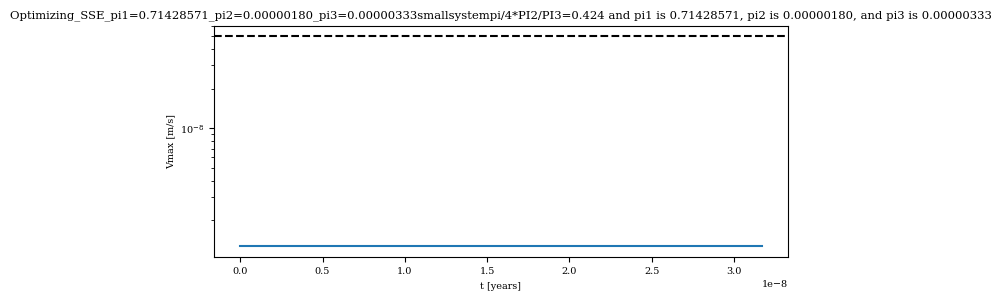

In [62]:
#%%
a_VW,b_VW,dc=[0.004,0.014,0.045]
W_asp=25000
POD_on_V=0
L_asp=cte.L_asp
L=cte.L_asp+cte.L_buffer    
stringadditional="smallsystem"
T_final=1
Specifyinit=False
u_init=0
p=forwardmodel(a_VW,b_VW,dc,W_asp,L,L_asp,stringadditional,T_final,u_init,Specifyinit)

In [63]:
index_tau=0
tau_list=np.array([0.1])
tau=tau_list[index_tau]
T_final=40*tau*t_yr # 10 tau just changed it for the simulations to be fater in debugging


In the following block, what I do, I want the starting time from which I want to do the forecast. Then I take the slip rate and theta from the inversion at that time and forward simulate from that initial condition. I record the rupture extent and time of the next event in order to quantify the prediction quality.

In [64]:
# TimeStarts_filtered = TimeStarts[mask]
# TimeEnds_filtered = TimeEnds[mask]
# rectangles_filtered = rectangles[mask,:]
# Mags_filtered = Mags[mask]

In [65]:
TimeStarts_filtered

array([1.87534884e+08, 2.01362341e+08, 9.86934734e+08])

In [66]:
V_ox_pred_events=[]
t_ox_pred_events=[]
TimeStarts_preds_events=[]
Mags_preds_events=[]
index_events=[]
# will use .append to save things in these arrays

In [67]:
def plotsliprate(index):
    # plotting Slip Rate
    V_thresh_min=1e-9
    V_thresh_max=1e-6   
    xlimleft=20
    xlimright=60
    fig = plt.figure(figsize=(7.7, 14))
    serif_font = fm.FontProperties(family="serif", size=8)
    cmap='jet'
    # Use serif font and set font size for all text in the figure
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.size': 8})
    gs = gridspec.GridSpec(nrows=2, ncols=2,width_ratios=[1,.03]) 

    axes1 = fig.add_subplot(gs[0, 0]) # True slip rate 
    axes2 = fig.add_subplot(gs[1, 0]) # observed slip rate
    # axes3 = fig.add_subplot(gs[2, 0]) # estimated slip rate
    # axes4 = fig.add_subplot(gs[3, 0]) # Error in slip rate
    # axes5 = fig.add_subplot(gs[4, 0]) # Error in slip rate
    # axes6 = fig.add_subplot(gs[5, 0]) # Error in slip rate
    # axes7 = fig.add_subplot(gs[6, 0]) # Error in slip rate
    # axes8 = fig.add_subplot(gs[7, 0]) # Error in slip rate
    # axes9 = fig.add_subplot(gs[8, 0]) # observed stress
    # axes10 = fig.add_subplot(gs[9, 0]) # inverted stress

    cax1 = fig.add_subplot(gs[0, 1])  
    cax2 = fig.add_subplot(gs[1, 1])  
    # cax3 = fig.add_subplot(gs[2, 1])  
    # cax4 = fig.add_subplot(gs[3, 1])
    # cax5 = fig.add_subplot(gs[4, 1])
    # cax6 = fig.add_subplot(gs[5, 1])
    # cax7 = fig.add_subplot(gs[6, 1])
    # cax8 = fig.add_subplot(gs[7, 1])
    # cax9 = fig.add_subplot(gs[8, 1])
    # cax10 = fig.add_subplot(gs[9, 1])
    # axes1 

    x_ox=np.linspace(-L/2,L/2,Nx)
    V_dip_mean=np.max(V_ox,axis=1).T   # Mean Velocity along the dip
    Nt=t_ox.shape[0]
    x_ox_t=np.vstack([x_ox]*Nt).T # what?
    time=np.max(t_ox,axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time  
    PrettyTime=np.reshape(time.T,-1)
    Prettyx=np.reshape(x_ox_t.T,-1)
    PrettyV=np.reshape(V_dip_mean.T,-1)
        
    pl=axes1.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))  
    axes1.set_xlabel(r'Time (year)',fontproperties=serif_font)
    axes1.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
    xlimleft=(time_inversion[index]+t_0_inversion)/t_yr
    xlimright=(time_inversion[index]+t_0_inversion)/t_yr+T_final/t_yr
    axes1.set_xlim(left=xlimleft,right=xlimright)
    b=fig.colorbar(pl,cax=cax1)
    b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
    axes1.set_ylim(bottom=-150,top=150)

    # axes2
    V_thresh_min=1e-9
    V_thresh_max=1e-6   
    x_ox=np.linspace(-L/2,L/2,Nx)
    V_dip_mean=np.max(V_ox_pred,axis=1).T   # Mean Velocity along the dip
    Nt=t_ox_pred.shape[0]
    
    x_ox_t=np.vstack([x_ox]*Nt).T # what?
    time=np.max(t_ox_pred,axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time  
    PrettyTime=np.reshape(time.T,-1)
    Prettyx=np.reshape(x_ox_t.T,-1)
    PrettyV=np.reshape(V_dip_mean.T,-1)
        
    pl=axes2.scatter(PrettyTime/t_yr+t_0_inversion/t_yr+time_inversion[index]/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))  
    axes2.set_xlabel(r'Time (year)',fontproperties=serif_font)
    axes2.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
    b=fig.colorbar(pl,cax=cax2)
    b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
    axes2.set_ylim(bottom=-150,top=150)

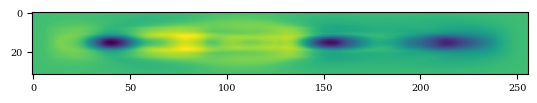

 Number of processors =            1
 Start reading input ...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh ...
 2D fault, uniform grid along-strike
 Impedance =    5000000.0000000000     
 Intializing kernel: ...
 Generating 3D kernel...
 OouraFFT applied along-strike
 Kernel intialized
 Values at selected point of the fault:

     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      0   0.000E+00   0.000E+00   0.305E-07   0.100E+02
      5   0.307E+03   0.122E-04   0.305E-07   0.100E+02
     10   0.996E+04   0.104E-02   0.277E-07   0.100E+02
     15   0.172E+05   0.328E-02   0.244E-07   0.100E+02
     20   0.244E+05   0.669E-02   0.226E-07   0.100E+02
     25   0.346E+05   0.115E-01   0.221E-07   0.100E+02
     30   0.504E+05   0.184E-01   0.232E-07   0.100E+02
     35   0.619E+05   0.274E-01   0.260E-07   0.100E+02
     40   0.760E+05   0.385E-01   0.

KeyboardInterrupt: 

: 

In [68]:
# for i in range(TimeStarts.shape[0]):
# recording the Time_starts, Time_ends, rectangles, and Mags predicted
# be careful you dont know how many events are there. right?
for i in range(Mags_filtered.shape[0]):

    # find the closest time to the TimeStarts[i]-tau
    index=np.argmin(np.abs(TimeStarts_filtered[i]-tau*t_yr-time_inversion)) # index of the closest time to the TimeStarts[i]-tau in the time_inversion
    # Take the initial condition at time index
    u_init=np.hstack([V_ox_ROM_inverted[index,:,:].ravel(),theta_ox_ROM_inverted[index,:,:].ravel()])
    u_init=np.log10(u_init)
    p=forwardmodel(a_VW,b_VW,dc,W_asp,L,L_asp,stringadditional,T_final,u_init,Specifyinit=True)
    # find the event extent and rupture area
    # do you remember how do you calculate the rupture area? 
    # you just need to find the rectangle of this p. that's it.
    # The easiest way is to find the rectangle it gives you the event time and extent 
    # you need V_ox_ROM, t_ox_ROM, V_thresh, L_thresh, t_yr, x_ox, z_ox, L_fault, mu
    # extracting necessary parameters from p
    Nt = len(p.ox["v"]) // (len(x_ox) * len(z_ox))
    # record all of the predictions in a list
    
    V_ox_pred = p.ox["v"].values.reshape((Nt, len(z_ox), len(x_ox)))
    t_ox_pred=p.ox["t"].values.reshape((Nt, len(z_ox), len(x_ox)))
    TimeStarts_pred,TimeEnds_pred,rectangles_pred,Mags_pred=Find_T_X_tau_without_p_input(V_ox_pred,t_ox_pred,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)
    V_ox_pred_events.append(V_ox_pred)
    t_ox_pred_events.append(t_ox_pred)
    TimeStarts_preds_events.append(TimeStarts_pred)
    Mags_preds_events.append(Mags_pred)
    index_events.append(index)
    print('Magnitude of the event in the data is ', Mags_filtered[i])
    print('Magnitude of the event in the prediction is ', Mags_pred)
    print('With the head time of',tau, 'The event is predicted to happen at',TimeStarts_pred[0]/t_yr)
    
    # you know what I want to plot? I want to plot the distribution of slip rate from headtime to tau and see how the prediction works.
    plotsliprate(index)
    
    
    

In [ ]:
# making the plot for the paper for the rupture extent

In [ ]:
index

3316

/central/groups/astuart/hkaveh/soft/miniconda3/envs/learnmodel/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


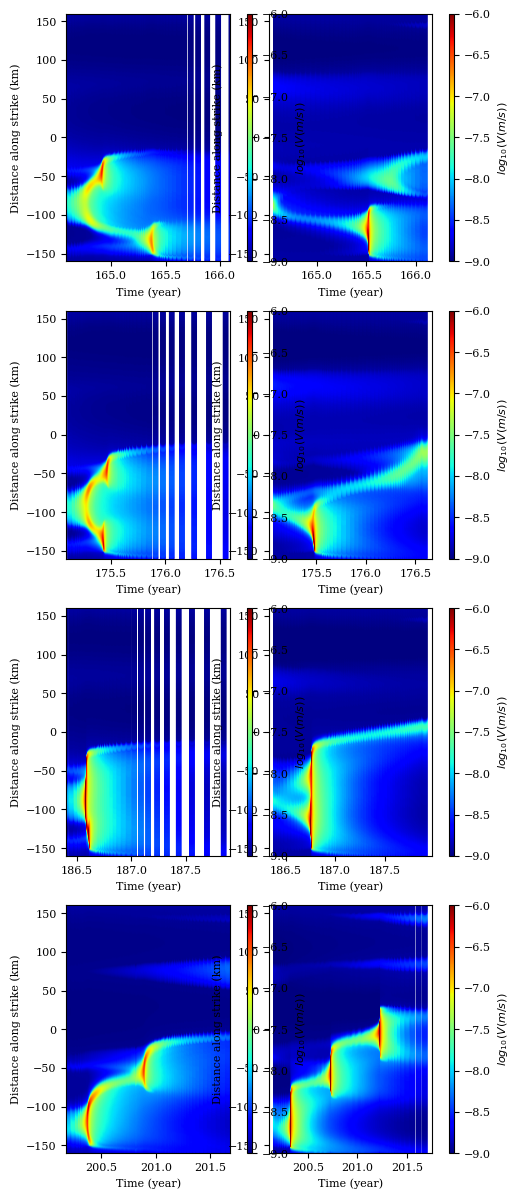

In [ ]:
# making a nice plot for the paper
# I am thinking of of 3 collomn figure with the first coloumn to be the QDYN simulation, the second one with N_m=20 and the third one to be N_m=30. 
# This should be a good idea that you can also see the difference in the forecast as well.

# To make this plot, I think it is better that you have already saved everything in the variables.
nrows=Mags_filtered.size
V_thresh_min=1e-9
V_thresh_max=1e-6  
x_ox=np.linspace(-L/2,L/2,Nx) 
# 1- define the figure size and the font size
fig = plt.figure(figsize=(5, nrows*3.7))
serif_font = fm.FontProperties(family="serif", size=8)
cmap='jet'
    # Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
gs = gridspec.GridSpec(nrows=nrows, ncols=4,width_ratios=[1,.03,1,0.03]) # I put 2 columns for now to wait to see how does the system look like for N_m=30
for counter in range(nrows):
    ax_qdyn= fig.add_subplot(gs[counter, 0]) # True slip rate
    ax_Nm20= fig.add_subplot(gs[counter, 2]) # Observed slip rate
    cax1 = fig.add_subplot(gs[counter, 1])  
    cax2 = fig.add_subplot(gs[counter, 3])  
    
    # Plotting the QDYN acutual slip profile
    V_dip_mean=np.max(V_ox,axis=1).T   # Mean Velocity along the dip
    Nt=t_ox.shape[0]
    x_ox_t=np.vstack([x_ox]*Nt).T # what?
    time=np.max(t_ox,axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time  
    PrettyTime=np.reshape(time.T,-1)
    Prettyx=np.reshape(x_ox_t.T,-1)
    PrettyV=np.reshape(V_dip_mean.T,-1)
    
    pl=ax_qdyn.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))  
    ax_qdyn.set_xlabel(r'Time (year)',fontproperties=serif_font)
    ax_qdyn.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
    xlimleft=(time_inversion[index_events[counter]]+t_0_inversion)/t_yr
    xlimright=(time_inversion[index_events[counter]]+t_0_inversion)/t_yr+T_final/t_yr
    ax_qdyn.set_xlim(left=xlimleft,right=xlimright)
    b=fig.colorbar(pl,cax=cax1)
    b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
    ax_qdyn.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
    # Plotting the N_m=20 slip profile
    V_dip_mean=np.max(V_ox_pred_events[counter],axis=1).T   # Mean Velocity along the dip
    Nt=t_ox_pred_events[counter].shape[0]
    x_ox_t=np.vstack([x_ox]*Nt).T # what?
    time=np.max(t_ox_pred_events[counter],axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time
    PrettyTime=np.reshape(time.T,-1)
    Prettyx=np.reshape(x_ox_t.T,-1)
    PrettyV=np.reshape(V_dip_mean.T,-1)
    
    pl=ax_Nm20.scatter(PrettyTime/t_yr+t_0_inversion/t_yr+time_inversion[index_events[counter]]/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))
    ax_Nm20.set_xlabel(r'Time (year)',fontproperties=serif_font)
    ax_Nm20.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
    b=fig.colorbar(pl,cax=cax2)
    b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
    ax_Nm20.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
    
    
    
plt.tight_layout()
plt.show()


In [ ]:
# saving V_ox_pred_events, t_ox_pred_events, TimeStarts_preds_events, Mags_preds_events, index_events
TimeStarts_filtered = TimeStarts[mask]
TimeEnds_filtered = TimeEnds[mask]
rectangles_filtered = rectangles[mask,:]
Mags_filtered = Mags[mask]


In [ ]:
if PlotSmallEvents==True:
    np.savez('/central/groups/astuart/hkaveh/Data/LearnROM/Prediction'+"N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+"tau"+str(tau)+"Mag_up"+str(Mag_upbound)+"Mag_low"+str(Mag_lowbound)+".npz",V_ox_pred_events=V_ox_pred_events,t_ox_pred_events=t_ox_pred_events,TimeStarts_preds_events=TimeStarts_preds_events,Mags_preds_events=Mags_preds_events,index_events=index_events,TimeStarts_filtered=TimeStarts_filtered,TimeEnds_filtered=TimeEnds_filtered,rectangles_filtered=rectangles_filtered,Mags_filtered=Mags_filtered)
else:
    np.savez('/central/groups/astuart/hkaveh/Data/LearnROM/Prediction'+"N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+"tau"+str(tau)+"Mag_thresh"+str(Mag_thresh)+".npz",V_ox_pred_events=V_ox_pred_events,t_ox_pred_events=t_ox_pred_events,TimeStarts_preds_events=TimeStarts_preds_events,Mags_preds_events=Mags_preds_events,index_events=index_events,TimeStarts_filtered=TimeStarts_filtered,TimeEnds_filtered=TimeEnds_filtered,rectangles_filtered=rectangles_filtered,Mags_filtered=Mags_filtered)